In [2]:
%matplotlib inline
import networkx as nx
import metis
import random
import pandas as pd
from tqdm import tqdm
from itertools import chain
from time import time
from matplotlib import pyplot as plt
from collections import Counter, defaultdict

from rwc import controversy_score
from leopard import update_partition

In [3]:
# running time and rwc score comparison
from util import sample_edges_to_add

def run_job(graph_pickle_path, edges_percent=0.1):
    g = nx.read_gpickle(graph_pickle_path)

    n_edges_to_add = n_edges_to_remove = int(g.number_of_edges() * edges_percent)
    edges_to_add = sample_edges_to_add(g, n_edges_to_add)
    edges_to_remove = random.sample(g.edges(), n_edges_to_remove)


    stat = {
        'name': os.path.basename(graph_pickle_path).split('.')[0]
    }
    cuts, node_cluster_ids = metis.part_graph(g, 2)
    rwc, aux_info = controversy_score(g, node_cluster_ids, 0.01)
    pr0, pr1 = aux_info['pr0'], aux_info['pr1']


    # update partition
    cuts, node_cluster_ids = metis.part_graph(g, 2)
    node_cluster_ids_inc = update_partition(g, node_cluster_ids=node_cluster_ids,
                                            edges_to_add=edges_to_add,
                                            edges_to_remove=edges_to_remove,
                                            verbose=False)
    pr0_new = {n: pr0.get(n, 0) for n in g.nodes_iter()}
    pr1_new = {n: pr1.get(n, 0) for n in g.nodes_iter()}

    s = time()
    rwc_inc, aux_info = controversy_score(g,
                                          node_cluster_ids_inc,
                                          0.01,
                                          nstart0=pr0_new,
                                          nstart1=pr1_new)

    stat['running_time_inc'] = time() - s
    stat['rwc_inc'] = rwc_inc

    _, node_cluster_ids_raw = metis.part_graph(g, 2)

    s = time()
    rwc_raw, aux_info = controversy_score(g, 
                                          node_cluster_ids_raw,
                                          0.01,
                                          nstart0=None,
                                          nstart1=None)
    stat['running_time_raw'] = time() - s
    stat['rwc_raw'] = rwc_raw
    return stat

In [4]:
run_job('data/beefban.gpkl')

{'name': 'beefban',
 'running_time_inc': 8.084237813949585,
 'running_time_raw': 9.208775520324707,
 'rwc_inc': 0.81853080618309182,
 'rwc_raw': 0.80747404452572935}

In [5]:
from glob import glob
from joblib import Parallel, delayed
rows = Parallel(n_jobs=8)(delayed(run_job)(path, edges_percent=0.01) for path in glob('data/*.gpkl'))
# for path in glob('data/*.gpkl'):
#     run_job('data/beefban.gpkl')

In [6]:
df = pd.DataFrame.from_records(rows)

In [7]:
from scipy.stats import pearsonr
cc, p = pearsonr(df['rwc_inc'], df['rwc_raw'])
print(cc, p)

0.997025687085 6.56342729535e-08


In [8]:
print('average running time reduction (percentage): {:.2f}'.format(((df['running_time_raw'] - df['running_time_inc']) / df['running_time_raw']).mean()))

average running time reduction (percentage): 0.38


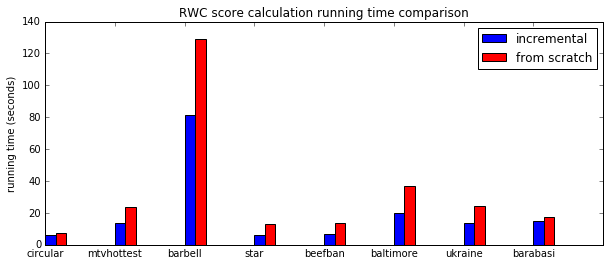

In [9]:
fig, ax = plt.subplots()
ind = np.arange(df.shape[0])
width = 0.15
ax.bar(ind, df['running_time_inc'], width, color='b')
ax.bar(ind+width, df['running_time_raw'], width, color='r')
ax.set_xticklabels(df['name'])
ax.set_ylabel('running time (seconds)')
ax.legend(['incremental', 'from scratch'])
fig.set_figwidth(10)
ax.set_title('RWC score calculation running time comparison')